<a href="https://colab.research.google.com/github/am610/DeepFake/blob/main/Sentinel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import cv2
import dlib
import glob
import json
import math
import random
import statistics
import tqdm.notebook as tqdm
import re
from pylab import *
from PIL import Image, ImageChops, ImageEnhance
from IPython import display
from timeit import default_timer as timer
from datetime import timedelta
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from google.colab.patches import cv2_imshow
from scipy.stats import ttest_1samp
from PIL import Image, ImageChops, ImageEnhance
import io
import base64
from IPython.display import HTML
import imageio
import matplotlib.animation as animation
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from skimage.transform import resize
import warnings

In [2]:
warnings.filterwarnings("ignore")
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
input_shape = (128, 128, 3)

# Add this folder to your google drive https://drive.google.com/drive/folders/1Zppu1TunpSD46r9n0rQhdrMVBrqLcIUx?usp=sharing



### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## Function Declaration
##### Function to Display video 

In [3]:
def display(driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = []
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani

##### Callback Function Declaration for CNN

In [4]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.997): # 3 sigma 
      print("\nReached 99.7% accuracy so cancelling training!")
      self.model.stop_training = True

In [63]:
def print_confusion_matrix(y_true, y_pred):
    warnings.filterwarnings("ignore")
    confusion = confusion_matrix(label, model1.predict_classes(X))
    #print(confusion)
    print('Accuracy% = ',(accuracy_score(label, model1.predict_classes(X), normalize=False)*100/len(label)))
    print(classification_report(label, model1.predict_classes(X)))
    total = (confusion[0][0]+confusion[0][1]+confusion[1][0]+confusion[1][1])
    fig, ax = plt.subplots()
    print('---------------------------')
    print('---------------------------')
    print('True positive = %s , (%.2f)%%'%(confusion[0][0],confusion[0][0]*100/total) )
    print('False positive = %s , (%.2f)%% '%(confusion[0][1],confusion[0][1]*100/total) )
    print('False negative = %s , (%.2f)%%'%(confusion[1][0],confusion[1][0]*100/total) )
    print('True negative =  %s , (%.2f)%%'%(confusion[1][1],confusion[1][1]*100/total) )
    print('---------------------------')
    print('---------------------------')
    print('\n')
    df_confusion = pd.DataFrame(confusion, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_confusion, annot=True, annot_kws={"size": 16},cmap="YlGnBu") # font size
    plt.ylabel('True label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.ylim([2, 0])
    xticklabels = ['     Fake', '     True']
    yticklabels = ['Fake', 'True']
    ax.set_xticklabels(xticklabels,rotation = 45)
    ax.set_yticklabels(yticklabels,rotation = 45)
    plt.show()    

In [50]:
# Hypothesis 1 sample t-test. 
# Assuming Null hypothesis  = Real Video. 
# Alternate Hypothesis = Fake Video
def hypothesis(hypo):
  tset, pval = ttest_1samp(hypo, 1)
  if (pval<0.05):
    print('Fake Video')
  else:
    print('Real Video')  

### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Mounting Drive. 
## Setting Path

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
print('CUDA usage: {}'.format(dlib.DLIB_USE_CUDA))

CUDA usage: True


##### Change your gdrive Path acordingly

In [9]:
DATA_PREFIX = '/content/gdrive/My Drive/Videos_DF/v/v2'

In [10]:
! rm -r '/content/gdrive/My Drive/Videos_DF/v/v2/dataset/real/'
! rm -r '/content/gdrive/My Drive/Videos_DF/v/v2/dataset/fake/'
! mkdir '/content/gdrive/My Drive/Videos_DF/v/v2/dataset/real/'
! mkdir '/content/gdrive/My Drive/Videos_DF/v/v2/dataset/fake/'
! ls '/content/gdrive/My Drive/Videos_DF/v/v2/dataset/real/'

### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Preprocessing : Reading the videos. 
##### The videos are located in two seperate folders, named as Real and Fake. We read them in and then using 'dlib' library focus on detecting there facial regions. Using 'Opencv2' we capture frames from the videos then we crop the aspect ratio and then the 'dlib' function checks for faces in them. We do this seperately for the two folders and store the captured images.

In [11]:
# Creating the input data from the real videos, for feeding into CNN engine.
input_path_real = DATA_PREFIX+'/real'#'/r_test'
list_of_real_video = [video for video in os.listdir(input_path_real) if video.endswith('.mp4')]

# Now creating the fake video's data
input_path_fake = DATA_PREFIX+'/fake'#'/f_test'
list_of_fake_video = [f for f in os.listdir(input_path_fake) if f.endswith('.mp4')]

In [12]:
detector = dlib.get_frontal_face_detector()

In [ ]:
# Real 
for vid in list_of_real_video:
    count_real = 0
    cap = cv2.VideoCapture(os.path.join(input_path_real, vid))
    frameRate = cap.get(5)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret != True:
            break
        if frameId % ((int(frameRate)+1)*1) == 0:
            face_rects, scores, idx = detector.run(frame, 0)
            for i, pos in enumerate(face_rects):
                left = pos.left()
                top = pos.top()
                right = pos.right()
                bottom = pos.bottom()
                crop_img = frame[top:bottom, left:right]
                if (np.shape(crop_img)[0]==0):
                  continue
                elif (np.shape(crop_img)[1]==0): 
                  continue
                elif (np.shape(crop_img)[2]==0): 
                  continue   
                cv2.imwrite(DATA_PREFIX+'/dataset/real/'+vid.split('.')[0]+'_'+str(count_real)+'.png', cv2.resize(crop_img, (128, 128)))
                print(count_real)
                count_real+=1

In [ ]:
#Fake
for vid in list_of_fake_video:
    count_fake = 0
    cap = cv2.VideoCapture(os.path.join(input_path_fake, vid))
    frameRate = cap.get(5)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret != True:
            break
        if frameId % ((int(frameRate)+1)*1) == 0:
            face_rects, scores, idx = detector.run(frame, 0)
            for i, pos in enumerate(face_rects):
                left = pos.left()
                top = pos.top()
                right = pos.right()
                bottom = pos.bottom()
                crop_img = frame[top:bottom, left:right] 
                if (np.shape(crop_img)[0]==0):
                  continue
                elif (np.shape(crop_img)[1]==0): 
                  continue
                elif (np.shape(crop_img)[2]==0): 
                  continue              
                cv2.imwrite(DATA_PREFIX+'/dataset/fake/'+vid.split('.')[0]+'_'+str(count_fake)+'.png', cv2.resize(crop_img, (128, 128)))
                print(count_fake)
                count_fake+=1

In [16]:
! ls   '/content/gdrive/My Drive/Videos_DF/v/v2/dataset/fake/' | wc -l
! ls   '/content/gdrive/My Drive/Videos_DF/v/v2/dataset/real/' | wc -l

11349
10161


##### Now we read in the pictures and convert them to arrays suitable for machine learning. We then split the whole data set into train test section in $80-20$ ratio.

In [17]:
input_dir = DATA_PREFIX+'/dataset'
real_data = [f for f in os.listdir(input_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(input_dir+'/fake') if f.endswith('.png')]
X = [];Y = [];factor = 255.0;
for img in real_data:
    X.append(img_to_array(load_img(input_dir+'/real/'+img)).flatten() / factor)
    Y.append(1) # 1 = Real
for img in fake_data:
    X.append(img_to_array(load_img(input_dir+'/fake/'+img)).flatten() / factor)
    Y.append(0) # 0 = Fake
label = Y
#Normalization
X = np.array(X);Y = to_categorical(Y, 2); # Binary Classification. 
#Reshape
print(np.shape(X))
X = X.reshape(-1, 128, 128, 3)
#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

(21510, 49152)


## Machine Learning : Convolutional Neural Network.
#### For the first convolution kernel we use the InceptionResNetV2. Res Net : Residual Network with Stochastic Gradient Descent. Based on [arxiv.org:1602.07261]. The inception ResNet V2, which is used here, is a convolutional neural network (CNN) that is trained on more than a million images from the ImageNet database. The network is 164 layers deep and can classify images into 1000 object categories. As a result, the network has learned rich feature representations for a wide range of images. We use pretrained 'imagenet' for weights initialization. 

In [6]:
def create_model():
  conv_base = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape) # 
  conv_base.trainable = True
  callbacks = myCallback()
  model = Sequential()
  model.add(conv_base)
  model.add(GlobalAveragePooling2D()) # GlobalMaxPooling2D
  #model.add(GlobalMaxPooling2D())
  #model.add(MaxPooling2D(4,4))
  #model.add(Dropout(0.8))
  model.add(Dense(units=2, activation='softmax')) # Classifier
  return model

In [18]:
model1 = create_model()
batch_size = 80
epochs = 100
callbacks = myCallback()
model1.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=1e-5),metrics=['accuracy'])
model1.summary()

219062272/219055592 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3074      
Total params: 54,339,810
Trainable params: 54,279,266
Non-trainable params: 60,544
_________________________________________________________________


In [19]:
history = model1.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val),callbacks=[callbacks] )

Epoch 1/100
216/216 [==============================] - 40s 185ms/step - loss: 0.5338 - accuracy: 0.7288 - val_loss: 0.4651 - val_accuracy: 0.7987
Epoch 2/100
216/216 [==============================] - 37s 169ms/step - loss: 0.3145 - accuracy: 0.8681 - val_loss: 0.3263 - val_accuracy: 0.8731
Epoch 3/100
216/216 [==============================] - 37s 169ms/step - loss: 0.2070 - accuracy: 0.9188 - val_loss: 0.2697 - val_accuracy: 0.8980
Epoch 4/100
216/216 [==============================] - 37s 169ms/step - loss: 0.1310 - accuracy: 0.9521 - val_loss: 0.2414 - val_accuracy: 0.9163
Epoch 5/100
216/216 [==============================] - 36s 169ms/step - loss: 0.0846 - accuracy: 0.9689 - val_loss: 0.2313 - val_accuracy: 0.9219
Epoch 6/100
216/216 [==============================] - 36s 169ms/step - loss: 0.0530 - accuracy: 0.9826 - val_loss: 0.2196 - val_accuracy: 0.9291
Epoch 7/100
216/216 [==============================] - 36s 169ms/step - loss: 0.0401 - accuracy: 0.9859 - val_loss: 0.2197 -

### Visualization and Model Quality Check

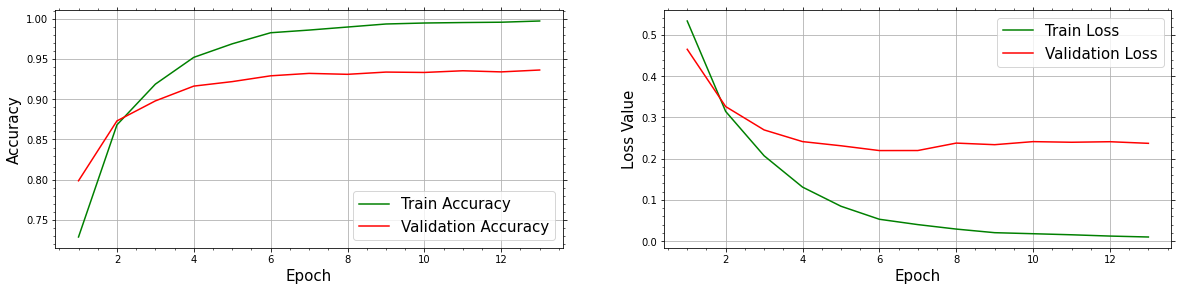

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
f.subplots_adjust(top=0.95, wspace=0.2)

#epoch_list = list(range(1,epoch+1))
epoch_list = list(range(1,len(history.history['accuracy'])+1))
ax1.plot(epoch_list, history.history['accuracy'],c='g', label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'],c='r', label='Validation Accuracy')
#ax1.set_xticks(np.arange(0, np.max(epoch_list), 2))
ax1.set_ylabel('Accuracy',fontsize=15)
ax1.set_xlabel('Epoch',fontsize=15)

ax1.minorticks_on()
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
l1 = ax1.legend(loc="best",fontsize=15)

ax2.plot(epoch_list, history.history['loss'],c='g', label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'],c='r', label='Validation Loss')
#ax2.set_xticks(np.arange(0, np.max(epoch_list), 2))
ax2.set_ylabel('Loss Value',fontsize=15)
ax2.set_xlabel('Epoch',fontsize=15)
ax2.minorticks_on()
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
l2 = ax2.legend(loc="best",fontsize=15)


Accuracy% =  98.50302185030219
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     11349
           1       0.98      0.99      0.98     10161

    accuracy                           0.99     21510
   macro avg       0.98      0.99      0.98     21510
weighted avg       0.99      0.99      0.99     21510

---------------------------
---------------------------
True positive = 11157 , (51.87)%
False positive = 192 , (0.89)% 
False negative = 130 , (0.60)%
True negative =  10031 , (46.63)%
---------------------------
---------------------------




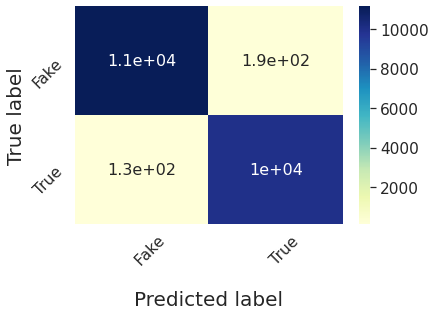

In [64]:
warnings.filterwarnings("ignore")
#Output confusion matrix
print_confusion_matrix(label, model1.predict_classes(X))

In [24]:
model1.save(DATA_PREFIX+'/dataset/model-2.h5')

In [ ]:
#model1 = load_model('/content/gdrive/My Drive/Videos_DF/v/v2/dataset/model.h5')